In [26]:
import pickle
import os
from data.pdb_utils import VOCAB
import torch
from torch_scatter import scatter_mean, scatter_sum
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import lmdb
from atom3d.datasets import LMDBDataset

from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

import prolif
from prolif.plotting.network import LigNetwork

# !!!!!!!!!!!
# Please run 'pip install -e .' in ProLIF directory to install prolif first (please use -e flag because the original code has been modified)
# !!!!!!!!!!!

# Specify Your Binding Complex of Interest & Number of Edge to Visualize & Paths

In [27]:
data_id = '7t2h'
percent_edge = 0.1
fragmentation = 'PS_300'

# LMDB_path = 'datasets/LBA/split-by-sequence-identity-30/data/test'
processed_data_path = 'datasets/customized/customized_LBA.LBADatasetPS_300_processed.pkl'
# processed_data_path = 'datasets/LBA/split-by-sequence-identity-30/data/test.LBADataset_processed.pkl'
Shapley_value_path = f'output/{data_id}/{data_id}_statistics.txt'

# Load Ligand

[01:56:17] EID: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


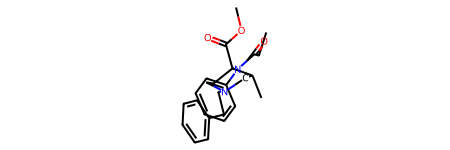

In [28]:
# load ligand data from .mol2
ligand_path = os.path.join('datasets/customized/customized_LBA/pdb_files', data_id,  data_id + '_ligand.mol2')
ligand_mol = Chem.MolFromMol2File(ligand_path, removeHs=False, sanitize=False)
ligand_mol

# Load Processed Data

In [29]:
# load data
with open(processed_data_path, 'rb') as f:
    data = pickle.load(f)

# get index and batch (binding complex) of interest
idx = [i for i, d in enumerate(data[1]) if d['id'] == data_id][0]
batch = data[2][idx]

In [30]:
# get useful data from batch
Z = torch.tensor(batch['X'])
B = torch.tensor(batch['B'])
A = torch.tensor(batch['A'])

block_lengths = torch.tensor(batch['block_lengths'])
Z = Z.reshape(Z.shape[0], 1, Z.shape[1])

# residue indices
indices = batch['indices']
list_indexes = batch['list_indexes']
residue_id = []
for b in list_indexes:
    residue_id.extend(b)
residue_id = [residue_id[i] for i in indices]

# chagne format from R_xxx to xxxR
residue_id = [f'{r[2:]}{r[0:1]}' for r in residue_id]

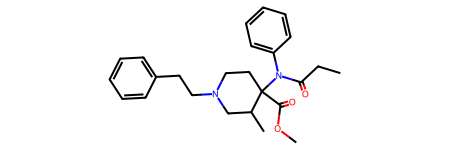

In [31]:
# get ligand
ligand_mol = batch['new_mol']
ligand_mol

In [32]:
# map fragment to atoms
frag_mol = batch['frag_mol']
frags = []
atom_idxs = []
for i in frag_mol:
    node = frag_mol.get_node(i)
    frags.append(node.smiles)
    atom_idxs.append(list(node.atom_mapping.keys()))

# for each row in atom_idxs, random choose one
atom_idxs_random_choice = [np.random.choice(i) for i in atom_idxs]

In [33]:
frags, atom_idxs

(['c1ccccc1', 'c1ccccc1', 'CCNC', 'CCC', 'COC=O', 'CCNC(=O)CC'],
 [[8, 7, 6, 5, 4, 3],
  [19, 18, 17, 16, 15, 14],
  [26, 13, 12, 11],
  [22, 21, 20],
  [29, 24, 28, 23],
  [27, 25, 10, 9, 2, 1, 0]])

In [34]:
# get coords of each amino acid and ligand atoms
with torch.no_grad():
    block_id = torch.zeros_like(A) # [Nu]
    block_id[torch.cumsum(block_lengths, dim=0)[:-1]] = 1
    block_id.cumsum_(dim=0)  # [Nu], block (residue) id of each unit (atom)
    
    assert Z.shape[1] == 1, "n_channel must be 1"
    top_Z = scatter_mean(Z, block_id, dim=0)  # [Nb, n_channel, 3]
B_coords = top_Z.reshape(top_Z.shape[0], top_Z.shape[2])

# coords of each amino acid and ligand atoms
B_coords.shape

torch.Size([45, 3])

In [35]:
# mol to smile
Chem.MolToSmiles(ligand_mol)

'CCC(=O)N(c1ccccc1)C1(C(=O)OC)CCN(CCc2ccccc2)CC1C'

In [36]:
# convert indexed data to name of amino acid and ligand atoms
VOCAB.load_tokenizer(fragmentation)
B_abrv = [VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(i)) for i in B]
# replace <G> with Global
B_abrv = ['Global' if abrv == '<G>' else abrv for abrv in B_abrv]
B_abrv

# start index in B_abrv of protein and ligand atoms
protein_start_idx = 1
ligand_start_idx = B_abrv.index('Global', 1)

In [37]:
B_abrv

['Global',
 'ALA',
 'THR',
 'LEU',
 'PRO',
 'PHE',
 'GLN',
 'SER',
 'ASN',
 'TYR',
 'LEU',
 'CYS',
 'VAL',
 'ILE',
 'ASP',
 'TYR',
 'TYR',
 'MET',
 'PHE',
 'ASP',
 'CYS',
 'THR',
 'LYS',
 'VAL',
 'PHE',
 'ALA',
 'CYS',
 'TRP',
 'ILE',
 'HIS',
 'VAL',
 'TRP',
 'CYS',
 'ILE',
 'ALA',
 'LEU',
 'GLY',
 'TYR',
 'Global',
 'c1ccccc1',
 'c1ccccc1',
 'CCNC',
 'CCC',
 'COC=O',
 'CCNC(=O)CC']

In [38]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand

# Load Shapley Value

In [39]:
with open(Shapley_value_path, 'r') as f:
    lines = f.readlines()
    shapley_dict = {}
    for line in lines[8:]:
        node_idx1 = int(line.split(',')[0].split('(')[1])
        node_idx2 = int(line.split(',')[1].split(')')[0])
        shapley_val = float(line.split(':')[-1])
        shapley_dict[(node_idx1, node_idx2)] = shapley_val

# descending sort the shapley_dict based on shapley_val
shapley_dict = dict(sorted(shapley_dict.items(), key=lambda item: item[1], reverse=True))

In [40]:
# the amino acid start index is 1 and ligand_start_idx-1 because of the Global at begaining of amino acid and ligand
# 
# filter only edge where node1 is amino acid and node2 is ligand atoms or vice versa
shapley_dict_bridge_edge = {k: v for k, v in shapley_dict.items() if (k[0] in range(1, ligand_start_idx-1) and k[1] in range(ligand_start_idx, len(B_abrv)+1)) or (k[0] in range(ligand_start_idx, len(B_abrv)+1) and k[1] in range(1, ligand_start_idx-1))}

# Min-Max normalize shapley_dict_bridge_edge from 0 to 1
shapley_dict_bridge_edge_normalized = {k: (v - min(shapley_dict_bridge_edge.values()))/(max(shapley_dict_bridge_edge.values())-min(shapley_dict_bridge_edge.values())) for k, v in shapley_dict_bridge_edge.items()}

In [41]:
# choose top k% of the edges
num_edge = int(len(shapley_dict_bridge_edge) * percent_edge)
num_edge

21

In [42]:
# get top edges with highest shapley value
top_edges = list(shapley_dict_bridge_edge.keys())[:num_edge]
top_edges_shapley = list(shapley_dict_bridge_edge.values())[:num_edge]

# reorder each edge in top_edges, where small index is node1 and large index is node2
top_edges = [edge if edge[0] < edge[1] else (edge[1], edge[0]) for edge in top_edges]
top_edges, top_edges_shapley, B_coords.shape, len(top_edges)

([(21, 39),
  (21, 40),
  (23, 42),
  (24, 39),
  (22, 39),
  (31, 44),
  (21, 43),
  (23, 40),
  (31, 43),
  (23, 41),
  (27, 39),
  (31, 39),
  (21, 41),
  (27, 44),
  (15, 42),
  (4, 44),
  (5, 40),
  (3, 40),
  (30, 43),
  (14, 44),
  (33, 39)],
 [0.10398333072662354,
  0.07741718292236328,
  0.06720048189163208,
  0.06645195484161377,
  0.06110183000564575,
  0.042460542917251584,
  0.03966591954231262,
  0.03934963941574097,
  0.03669137954711914,
  0.034870976209640504,
  0.034014588594436644,
  0.03342305421829224,
  0.03213561177253723,
  0.028667518496513368,
  0.028261551260948183,
  0.024959418177604675,
  0.02377140522003174,
  0.02318512499332428,
  0.022542712092399598,
  0.02144572287797928,
  0.021426939964294435],
 torch.Size([45, 3]),
 21)

# Visualize Using prolif

In [43]:
# a function to calculate distance between two atoms
def calc_distance(node1, node2):
    # just use euclidean distance
    return np.linalg.norm(B_coords[node1] - B_coords[node2])

In [44]:
# construct dataframe for prolif
df = pd.DataFrame(columns=["ligand", "protein", "interaction", "atoms", "weight", "distance"])

VOCAB.load_tokenizer(fragmentation)
B_abrv = [VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(i)) for i in B]
# iterate through top_20_edges. for each edge, store ligand as 1c86; then map node1 to VOCAB, store as protein; store node2 as atoms; store shapley value as weight; then using calc_distance to calculate distance, and store distance 
for i, edge in enumerate(top_edges):
    if edge[0] == ligand_start_idx-1:
        continue
    ligand = data_id
    # idx here is the idx in the B, use B[idx] to map back to amino acid or atom number
    protein = VOCAB.symbol_to_abrv(VOCAB.idx_to_symbol(B[edge[0]])) + str(residue_id[edge[0]-1])
    # atom_idx = int(edge[1]-ligand_start_idx)
    atom_idx = atom_idxs_random_choice[edge[1]-ligand_start_idx-1]
    # create a tuple with only 1 element
    atoms = (atom_idx,)
    interaction = "Shapley Value"
    weight = top_edges_shapley[i] * 30
    distance = calc_distance(edge[0], edge[1])
    df = pd.concat([df, pd.DataFrame({"ligand": ligand, "protein": protein, "interaction": interaction, "atoms": atoms, "weight": weight, "distance": distance})], ignore_index=True)

# set atoms type to tuple
df.atoms = df.atoms.apply(lambda x: (x,))

# order by protein, interaction, atoms
df.sort_values(by=["ligand", "protein", "interaction", "atoms"], inplace=True)
df.set_index(["ligand", "protein", "interaction", "atoms"], inplace=True)
df

/tmp/ipykernel_268577/3211182182.py:20: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



weight   distance
ligand protein interaction   atoms                     
7t2h   ASP147D Shapley Value (2,)   0.643372   7.555810
       ILE322D Shapley Value (5,)   0.642808   5.612205
       LEU121D Shapley Value (16,)  0.695554   8.833912
       LYS233D Shapley Value (5,)   1.833055  11.788715
       PHE123D Shapley Value (16,)  0.713142   7.336211
       PHE237D Shapley Value (5,)   1.993559  12.376028
       PRO122D Shapley Value (2,)   0.748783  15.773339
       THR218D Shapley Value (5,)   3.119500  15.112391
                             (11,)  0.964068   9.118918
                             (16,)  2.322515   7.750083
                             (29,)  1.189978  10.984107
       TRP293D Shapley Value (2,)   0.860026   8.304258
                             (5,)   1.020438   6.556646
       TRP318D Shapley Value (2,)   1.273816   8.598182
                             (5,)   1.002692   9.693690
                             (29,)  1.100741   6.610874
       TYR148D Shapley Value (21,)  0.847847   4.585152
       VAL236D Shapley Value (11,)  1.046129  11.741708
                             (16,)  1.180489  15.649026
                             (21,)  2.016014   8.795728
       VAL300D Shapley Value (29,)  0.676281   6.924714

# If edges clustered together, run the below code block again to generate another plot

# Please Ignore the Hydrophobic in the bottom left, this is WRONG information 

In [45]:
# construct prolif network and visualize

lg = LigNetwork(df, ligand_mol)
# set color for edge
lg.COLORS['interactions']['Shapley Value'] = '#59e382'
lg.display()